# Import Library

In [34]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
from ultralytics import YOLO
import os
import yaml


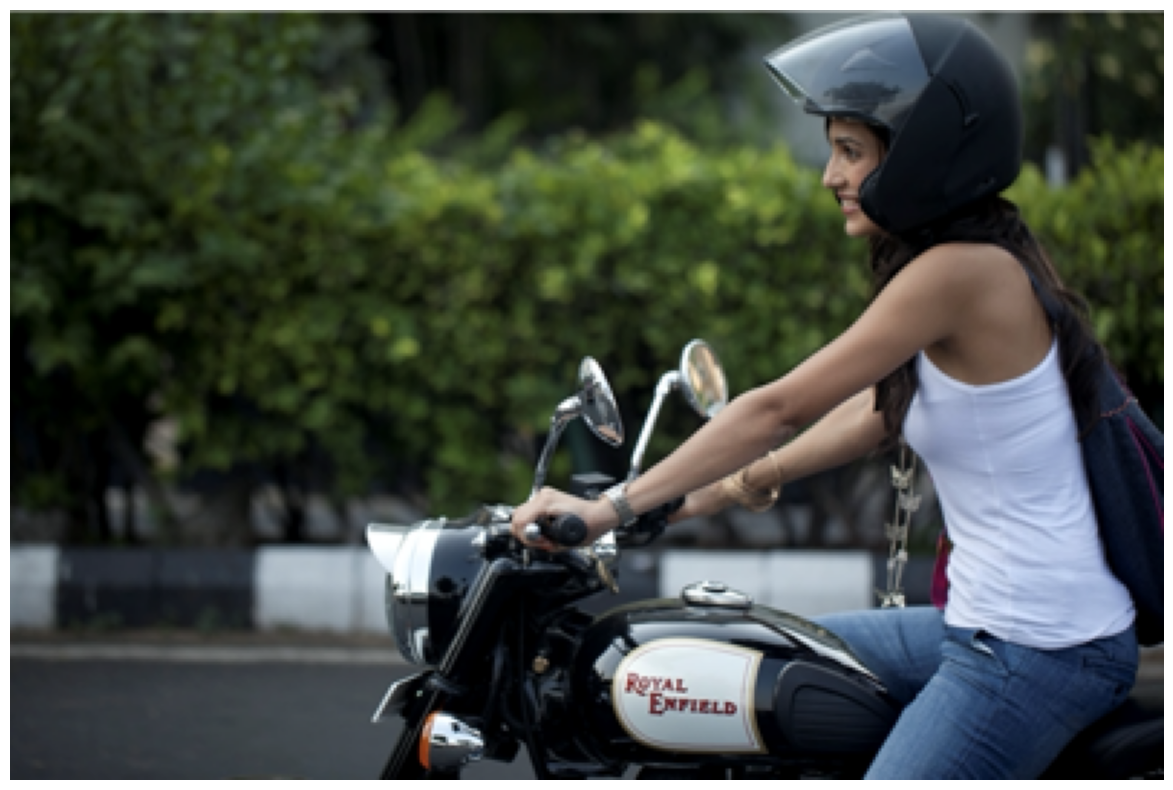

In [28]:
img0 = r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images\BikesHelmets90.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))

# Converting XML to YOLO format

In [7]:
import xml.etree.ElementTree as ET
import glob
import os
import json


def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []
input_dir = r"C:\Users\Nitin\Downloads\sujit\Helmet Detection\annotations"
output_dir = r"C:\Users\Nitin\Downloads\sujit\Helmet Detection\labels"  
image_dir = r"C:\Users\Nitin\Downloads\sujit\Helmet Detection\images"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))
    
print("XML to YOLO Format Done!!")


XML to YOLO Format Done!!


# Drawing a bounding box

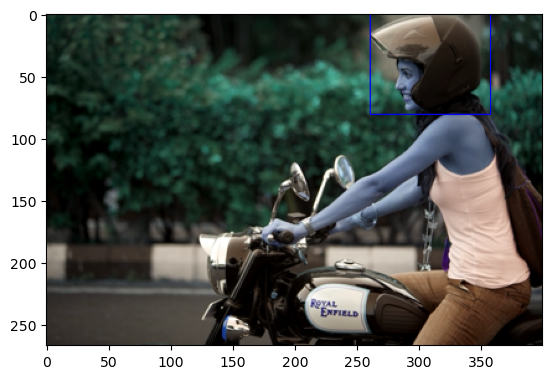

In [30]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images\BikesHelmets90.png")
dh, dw, _ = img.shape

fl = open(r"C:\Users\nitin\Downloads\sujit\Helmet Detection\labels\BikesHelmets90.txt", 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()


# Train Test Split
## There shouldn't be labels, train, val, test folder in working directory

In [10]:
from sklearn.model_selection import train_test_split
import shutil
import os


IMAGES_PATH = r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images"
LABELS_PATH = r"C:\Users\nitin\Downloads\sujit\Helmet Detection\labels"  

# Read labels
labels = os.listdir(LABELS_PATH)

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")

def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.png"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

print("Train Test Split Done!!")

train: 646; valid: 92; test: 23


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'test/images'

# Create a dataset.yaml File

In [13]:

# Define the paths and configuration
dataset_config = {
    "train": r"C:\Users\nitin\Downloads\sujit\train\images",  # Path to the training images
    "val": r"C:\Users\nitin\Downloads\sujit\valid\images",    # Path to the validation images
    "test": r"C:\Users\nitin\Downloads\sujit\test\images",    # Path to the test images
    "nc": 2,               # Number of classes (2 for helmet and Without Helmet)
    "names": ['helmet', "Without Helmet"],  # Class names
    "labels": r"C:\Users\nitin\Downloads\sujit\train\labels",      # Path to the labels for the training images
    "val_labels": r"C:\Users\nitin\Downloads\sujit\valid\labels",  # Path to the labels for the validation images
    "test_labels": r"C:\Users\nitin\Downloads\sujit\test\labels"   # Path to the labels for the test images
}

# Specify the path to save the dataset.yaml configuration
yaml_file_path = "dataset.yaml"

# Save the dataset.yaml configuration to the specified file path
with open(yaml_file_path, "w") as yaml_file:
    yaml.dump(dataset_config, yaml_file, default_flow_style=False)

print(f"dataset.yaml created successfully at path: {os.path.abspath(yaml_file_path)}")


dataset.yaml created successfully at path: C:\Users\Sujit Chaudhary\Downloads\sujit\dataset.yaml


# Training YOLO

# Helmet detection


0: 448x640 1 helmet, 401.9ms
Speed: 13.8ms preprocess, 401.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


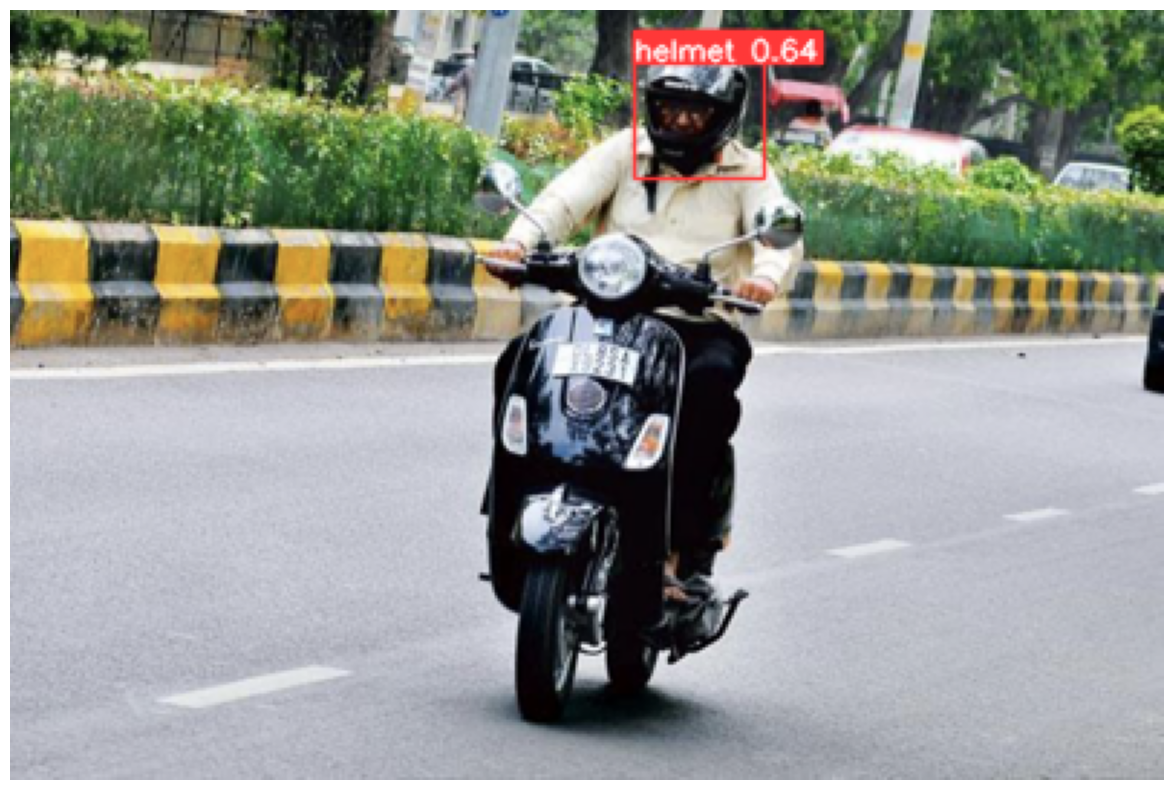

In [36]:
model = YOLO(r"C:\Users\nitin\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images\BikesHelmets92.png")
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))


0: 448x640 1 Without Helmet, 418.8ms
Speed: 0.0ms preprocess, 418.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


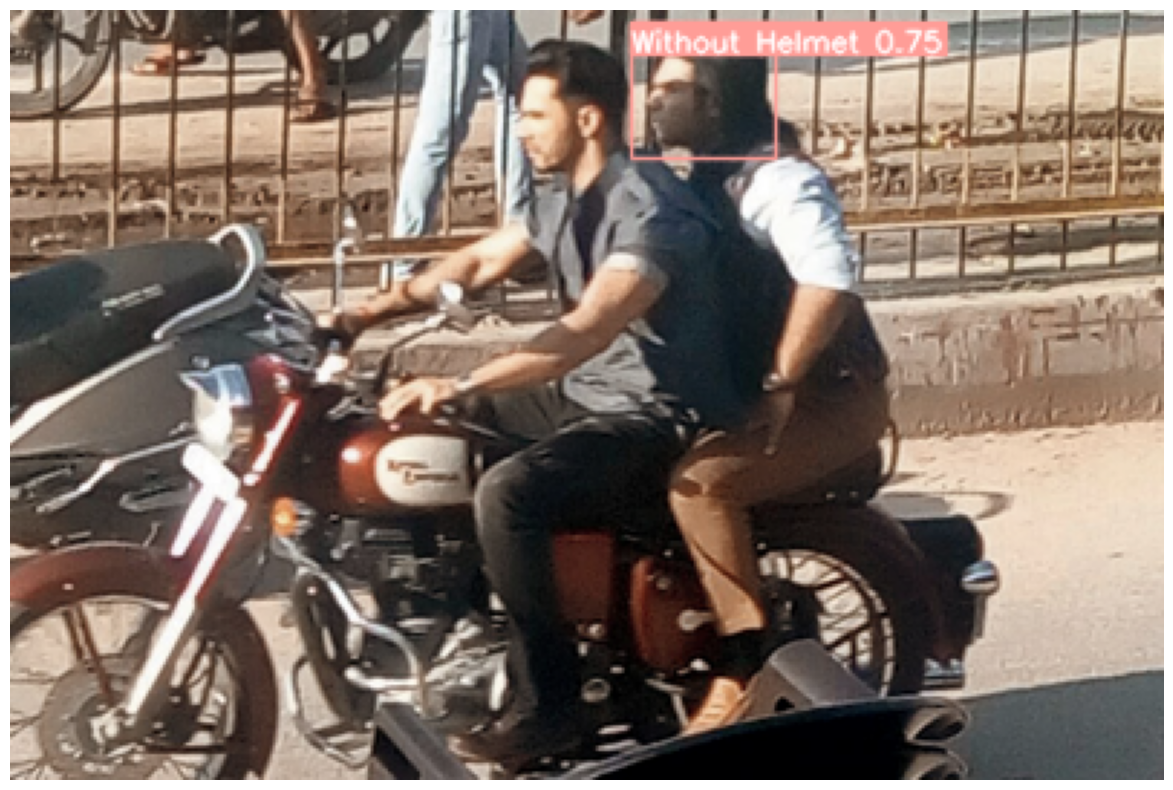

In [37]:
model = YOLO(r"C:\Users\nitin\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images\BikesHelmets93.png")
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))


0: 448x640 1 helmet, 562.6ms
Speed: 22.2ms preprocess, 562.6ms inference, 7.5ms postprocess per image at shape (1, 3, 448, 640)


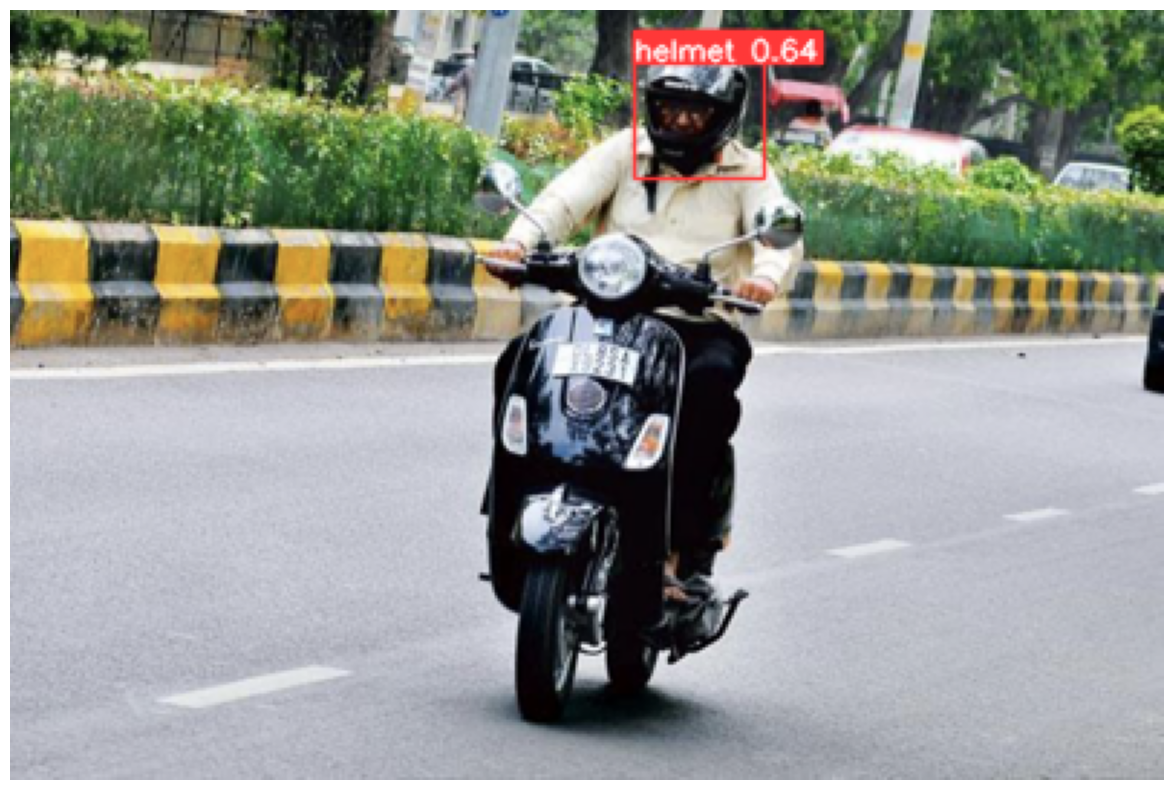

In [38]:
model = YOLO(r"C:\Users\nitin\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\nitin\Downloads\sujit\Helmet Detection\images\BikesHelmets92.png")
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))